In [ ]:
#|default_exp relora

# ReLoRA BitNet training

> The implementation of ReLoRA training method for my implementation of BitNet forward pass

## Idea

The key idea of ReLoRA ( https://arxiv.org/pdf/2307.05695.pdf ) is to make a high-rank updates as a series of low-rank updates.

For that they introduce a training procedure where
- they add LoRA adapters to the linear layers of the original network
- each N steps they:
  - merge LoRA back in the original layer
  - reset LoRA adapter state
  - reset optimizer state
  - reset LR to zero to make some quick warmup

In my case I will apply LoRA to the BitNet-approach quantized weights during training, while during merging I will apply them to the original weights (and quantize them back later). This will introduce quality loss, but it's yet to see how much for big networks.

## Implementation

In [ ]:
#| export
from typing import Type, Any, Dict, Iterable, Callable, Union, List
import torch
from torch.utils.data import TensorDataset, DataLoader
from bitlinear.bitlinear import BitLinear
from bitlinear.adapters import LoRAAdapter, MergeableLayer
from torch.optim import Adam, Optimizer
from torch.optim.lr_scheduler import LambdaLR
import gc
import pickle

In [ ]:
import matplotlib.pyplot as plt
import tempfile

### ReLoRA style `Optimizer`

This "optimizer" will:
- use some other optimizer inside (see `optimizer_cls` / `optimizer_params` / `lr`)
- reset it every `reset_n_steps` steps
- call merge every `reset_n_steps` steps (see `mergeable_layers`)
- also will be a proxy for a few inner optimizer things necessary to work properly

In [ ]:
#| export
class ReLoRAOptimizer(Optimizer):
    def __init__(self,
                 params: Iterable[torch.Tensor] | Iterable[Dict[str, Any]],
                 mergeable_layers: Iterable[MergeableLayer],
                 optimizer_cls: Type[Optimizer],
                 optimizer_params: Dict[str, Any],
                 reset_n_steps: int,
                 lr: float = 1e-3,) -> None:
        params_list = list(params)
        self.inner_params = params_list
        self.optimizer_cls = optimizer_cls
        self.optimizer_params = optimizer_params
        self.lr = lr
        
        # Some trickery around param_groups require me to re-initialize stuff
        self.optimizer = self._initialize_optimizer()
        super(ReLoRAOptimizer, self).__init__(params_list, {})
        self.optimizer = self._initialize_optimizer()
        self._cleanup()

        self.mergeable_layers = mergeable_layers
        self.reset_n_steps = reset_n_steps
        self.made_steps = 0
    
    def _cleanup(self):
        gc.collect()
        torch.cuda.empty_cache()

    def _initialize_optimizer(self) -> Optimizer:
        params = dict(lr=self.lr, **self.optimizer_params)
        return self.optimizer_cls(self.inner_params, **params)
    
    def zero_grad(self, set_to_none: bool = True) -> None:
        return self.optimizer.zero_grad(set_to_none=set_to_none)
    
    def step(self, *args, **kwargs) -> None:
        self.optimizer.step(*args, **kwargs)
        if self.made_steps > 0 and self.made_steps % self.reset_n_steps == 0:
            for layer in self.mergeable_layers:
                layer.merge_adapter()
            self.optimizer = None
            self._cleanup()
            self.optimizer = self._initialize_optimizer()
        self.made_steps += 1

    @property
    def param_groups(self):
        groups = []
        for group in self.optimizer.param_groups:
            if 'lr' not in group:
                group['lr'] = self.lr
            groups.append(group)
        return groups
    
    @param_groups.setter
    def param_groups(self, groups):
        self.optimizer.param_groups = groups

    def state_dict(self) -> Dict[str, Any]:
        return self.optimizer.state_dict()
    
    def load_state_dict(self, state_dict: Dict[str, Any]) -> None:
        return self.optimizer.load_state_dict(state_dict)

### ReLoRA style LR scheduler

This callable will:

- use some `lr_lambda` inside it for a factual schedule
- but on top of that make some quick (`warmup_n_steps`) warmups every `reset_n_steps` steps

In [ ]:
#| export
def is_pickleable(obj: Any) -> bool:
    try:
        pickle.dumps(obj)
        return True
    except:
        return False

In [ ]:
#| export
class ReLoRASchedulerLambda:
    def __init__(self, lr_lambda: callable, reset_n_steps: int, warmup_n_steps: int):
        assert is_pickleable(lr_lambda), "lr_lambda should be a pickleable object to use in the training process. " + \
            "Otherwise many popular trainer loop implementations will fail"
        self.func = self._wrap_lr_lambda(lr_lambda)
        self.reset_n_steps = reset_n_steps
        self.warmup_n_steps = warmup_n_steps
    
    def __call__(self, *args: Any, **kwargs: Any) -> Any:
        return self.func(*args, **kwargs)
    
    def _wrap_lr_lambda(self, func):
        def _func(step):
            if step % self.reset_n_steps < self.warmup_n_steps:
                k = (step % self.reset_n_steps) / self.warmup_n_steps
            else:
                k = 1
            value = func(step) * k
            return value
        
        return _func

### Test

For test I will just make a XOR network and compare the way it works with a basic FP32 multilayer perceptron.

#### Dataset preparation

In [ ]:
torch.manual_seed(42)
x_orig = torch.Tensor([
    [0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0],
    [1, 0, 0, 0, 0],
    [1, 1, 0, 0, 0],
])
y_orig = torch.FloatTensor([
    [0],
    [1],
    [1],
    [0],
])
x = []
y = []
for i in range(500000):
    x.append(x_orig + torch.rand(size=x_orig.shape) * 0.2 - 0.1)
    y.append(y_orig)
x = torch.cat(x, dim=0)
y = torch.cat(y, dim=0)
dataset = TensorDataset(x, y)

#### BitNet ReLoRA XOR

In [ ]:
class LinearWarmupSchedule:
    def __init__(self, warmup_steps, all_steps) -> None:
        self.warmup_steps = warmup_steps
        self.all_steps = all_steps
    
    def __call__(self, step):
        if step < self.warmup_steps:
            return step / self.warmup_steps
        else:
            return 1.0 - (step - self.warmup_steps) / (self.all_steps - self.warmup_steps)

In [ ]:
def test_training(device):
    torch.manual_seed(42)
    with tempfile.NamedTemporaryFile() as weights_temp_file_0, \
        tempfile.NamedTemporaryFile() as weights_temp_file_1:
        weights_temp_file_0_name = weights_temp_file_0.name
        weights_temp_file_1_name = weights_temp_file_1.name
        dataloader = DataLoader(dataset, batch_size=100)
        dataloader_iter = iter(dataloader)

        lora_0 = LoRAAdapter(
            in_features=5,
            out_features=10,
            lora_rank=2,
            device=device,
        )
        lora_1 = LoRAAdapter(
            in_features=10,
            out_features=1,
            lora_rank=2,
            device=device,
        )
        layer_0 = BitLinear(
            in_features=5,
            out_features=10,
            bias=True,
            device=device,
            original_weights_filename=weights_temp_file_0_name,
            adapter=lora_0,
        )
        layer_1 = BitLinear(
            in_features=10,
            out_features=1,
            device=device,
            original_weights_filename=weights_temp_file_1_name,
            adapter=lora_1,
        )
        network = torch.nn.Sequential(
            layer_0,
            torch.nn.GELU(),
            layer_1,
            torch.nn.Sigmoid()
        )
        loss = torch.nn.BCELoss()

        losses = []
        optimizer = ReLoRAOptimizer(
            network.parameters(),
            mergeable_layers=[
                layer_0, layer_1,
            ],
            optimizer_cls=Adam,
            optimizer_params={},
            reset_n_steps=250,
            lr=1e-3,
        )
        lr_scheduler = LambdaLR(
            optimizer,
            ReLoRASchedulerLambda(
                LinearWarmupSchedule(250, 5000),
                reset_n_steps=250,
                warmup_n_steps=25,
            ),
        )

        network.train()
        lrs = []
        for _ in range(5000):
            optimizer.zero_grad()
            batch = next(dataloader_iter)
            x, y = batch
            y_pred = network(x.to(device))
            loss_value = loss(y_pred, y.to(device))
            loss_value.backward()
            losses.append(loss_value.item())
            optimizer.step()
            lr_scheduler.step()
            lr = optimizer.state_dict()['param_groups'][0]['lr']
            lrs.append(lr)
        
        assert loss_value.item() < 0.2, f"Expected loss<0.2, got {loss_value}"

        plt.plot(losses)
        plt.ylabel("Loss")
        plt.xlabel("Steps")
        plt.title("1.5bit ReLoRA XOR loss")
        plt.grid()
        plt.show()

        plt.plot(lrs)
        plt.ylabel("LR")
        plt.xlabel("Steps")
        plt.title("1.5bit ReLoRA XOR LR")
        plt.grid()
        plt.show()

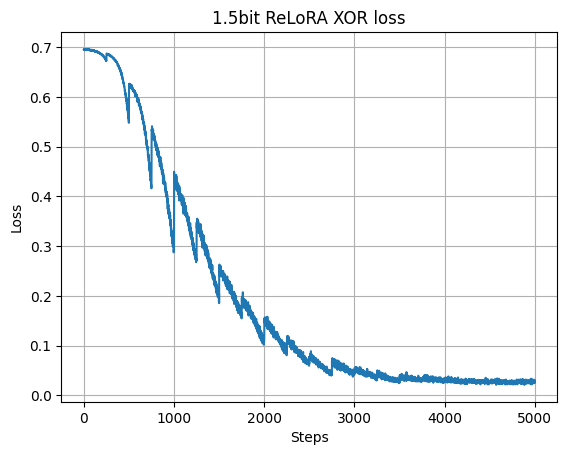

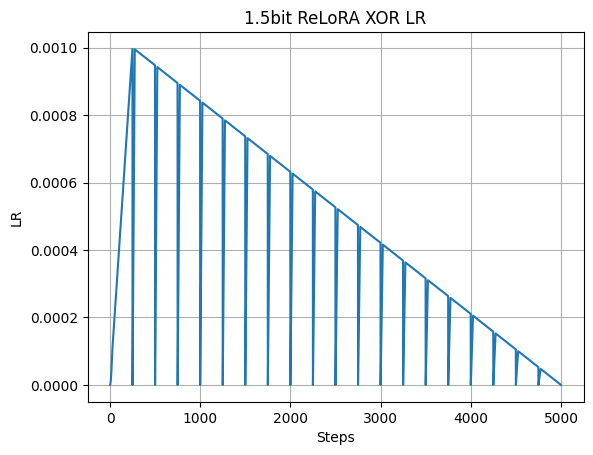

In [ ]:
test_training("cpu")

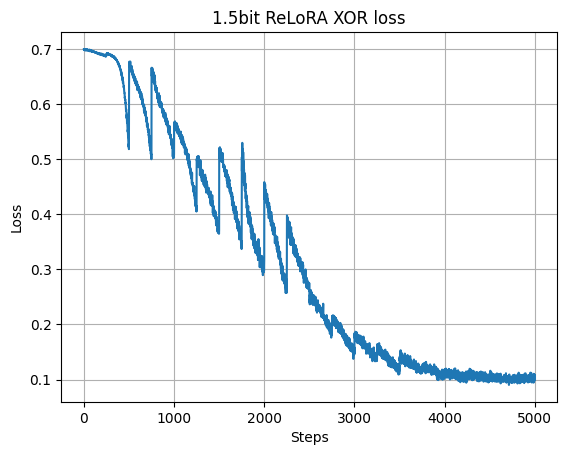

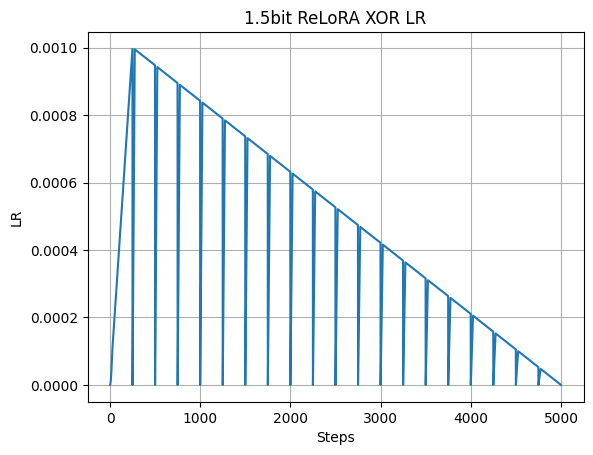

In [ ]:
if torch.cuda.is_available():
    test_training("cuda:0")

Here:
- we see time was quite long (9.6 sec CPU, 11 sec GPU) - yet as the further profiling will show it's ReLoRA resets which consume much time, so perhaps it will be lesser part of the process than updates themselves for bigger network
- we see quality losses every 250 steps which must be expected - every time I apply LoRA to the original weights, not the quantized it were trained for, and quantize it once again

#### XOR based on `nn.Linear`

In [ ]:
def test_normal(device):
    torch.manual_seed(42)
    dataloader = DataLoader(dataset, batch_size=100)
    dataloader_iter = iter(dataloader)

    layer_0 = torch.nn.Linear(
        in_features=5,
        out_features=10,
        bias=True,
        device=device,
    )
    layer_1 = torch.nn.Linear(
        in_features=10,
        out_features=1,
        bias=True,
        device=device,
    )
    network = torch.nn.Sequential(
        layer_0,
        torch.nn.GELU(),
        layer_1,
        torch.nn.Sigmoid()
    )
    loss = torch.nn.BCELoss()

    losses = []
    optimizer = Adam(
        network.parameters(),
        lr=1e-3,
    )
    lr_scheduler = LambdaLR(
        optimizer,
        LinearWarmupSchedule(250, 5000),
    )
    network.train()
    lrs = []
    for _ in range(5000):
        optimizer.zero_grad()
        batch = next(dataloader_iter)
        x, y = batch
        y_pred = network(x.to(device))
        loss_value = loss(y_pred, y.to(device))
        loss_value.backward()
        losses.append(loss_value.item())
        optimizer.step()
        lr_scheduler.step()
        lr = optimizer.state_dict()['param_groups'][0]['lr']
        lrs.append(lr)
        
    assert loss_value.item() < 0.2, f"Expected loss<0.2, got {loss_value}"

    plt.plot(losses)
    plt.ylabel("Loss")
    plt.xlabel("Steps")
    plt.title("XOR loss")
    plt.grid()
    plt.show()

    plt.plot(lrs)
    plt.ylabel("LR")
    plt.xlabel("Steps")
    plt.title("XOR LR")
    plt.grid()
    plt.show()

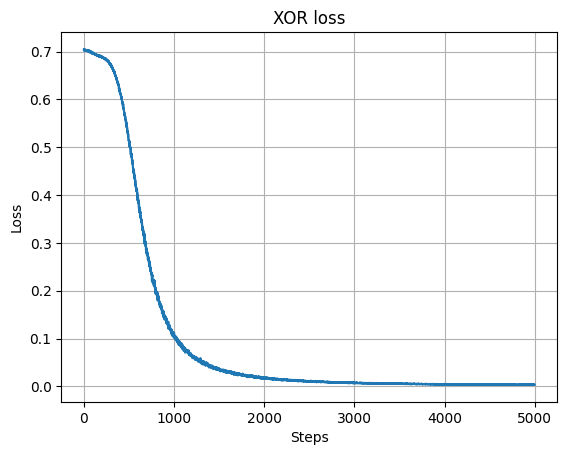

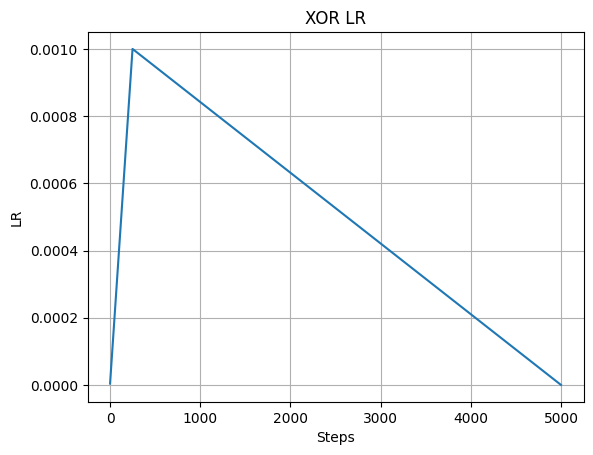

In [ ]:
test_normal("cpu")

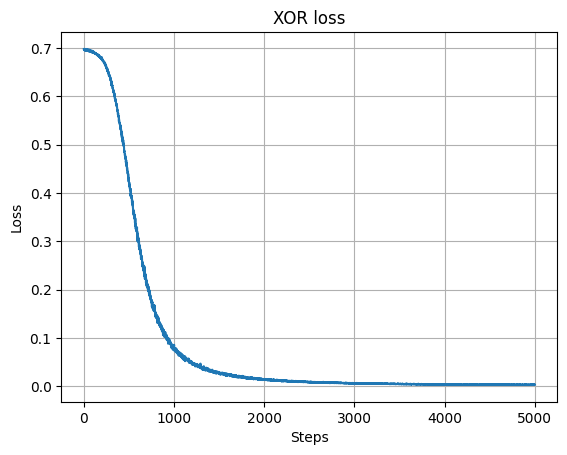

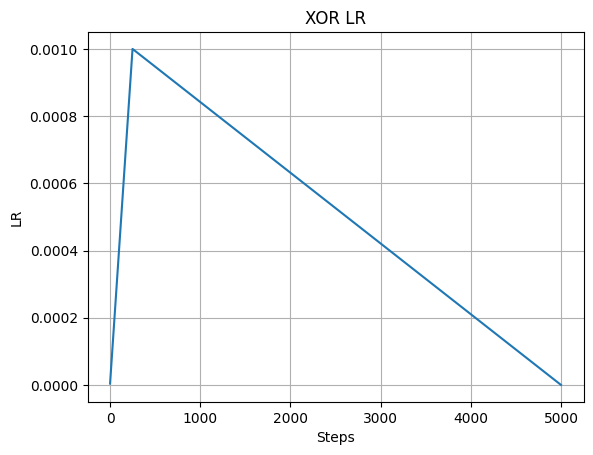

In [ ]:
if torch.cuda.is_available():
    test_normal("cuda:0")

So it surely comes to an optimal state faster with such a small network. Let's see bigger ones in the further work.

#### CUDA+autocast

In [ ]:
def test_training_cuda_autocast():
    device = "cuda:0"
    torch.manual_seed(42)
    with tempfile.NamedTemporaryFile() as weights_temp_file_0, \
        tempfile.NamedTemporaryFile() as weights_temp_file_1:
        weights_temp_file_0_name = weights_temp_file_0.name
        weights_temp_file_1_name = weights_temp_file_1.name
        dataloader = DataLoader(dataset, batch_size=100)
        dataloader_iter = iter(dataloader)

        lora_0 = LoRAAdapter(
            in_features=5,
            out_features=10,
            lora_rank=2,
            device=device,
        )
        lora_1 = LoRAAdapter(
            in_features=10,
            out_features=1,
            lora_rank=2,
            device=device,
        )
        layer_0 = BitLinear(
            in_features=5,
            out_features=10,
            bias=True,
            device=device,
            original_weights_filename=weights_temp_file_0_name,
            adapter=lora_0,
        )
        layer_1 = BitLinear(
            in_features=10,
            out_features=1,
            device=device,
            original_weights_filename=weights_temp_file_1_name,
            adapter=lora_1,
        )
        network = torch.nn.Sequential(
            layer_0,
            torch.nn.GELU(),
            layer_1,
        )
        loss = torch.nn.BCEWithLogitsLoss()

        losses = []
        optimizer = ReLoRAOptimizer(
            network.parameters(),
            mergeable_layers=[
                layer_0, layer_1,
            ],
            optimizer_cls=Adam,
            optimizer_params={},
            reset_n_steps=250,
            lr=1e-3,
        )
        lr_scheduler = LambdaLR(
            optimizer,
            ReLoRASchedulerLambda(
                LinearWarmupSchedule(250, 5000),
                reset_n_steps=250,
                warmup_n_steps=25,
            ),
        )
        network.train()
        scaler = torch.cuda.amp.GradScaler()
        lrs = []
        for _ in range(5000):
            optimizer.zero_grad()
            batch = next(dataloader_iter)
            x, y = batch
            with torch.cuda.amp.autocast(enabled=True):
                y_pred = network(x.to(device))
                loss_value = loss(y_pred, y.to(device))
            
            losses.append(loss_value.item())
            
            scaler.scale(loss_value).backward()
            
            scaler.step(optimizer)
            scaler.update()

            lr_scheduler.step()
            lr = optimizer.state_dict()['param_groups'][0]['lr']
            lrs.append(lr)
        
        assert loss_value.item() < 0.2, f"Expected loss<0.2, got {loss_value}"

        plt.plot(losses)
        plt.ylabel("Loss")
        plt.xlabel("Steps")
        plt.title("1.5bit ReLoRA XOR loss")
        plt.grid()
        plt.show()

        plt.plot(lrs)
        plt.ylabel("LR")
        plt.xlabel("Steps")
        plt.title("1.5bit ReLoRA XOR LR")
        plt.grid()
        plt.show()

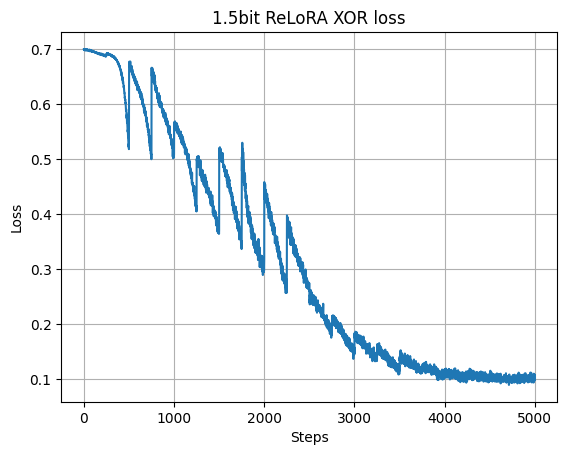

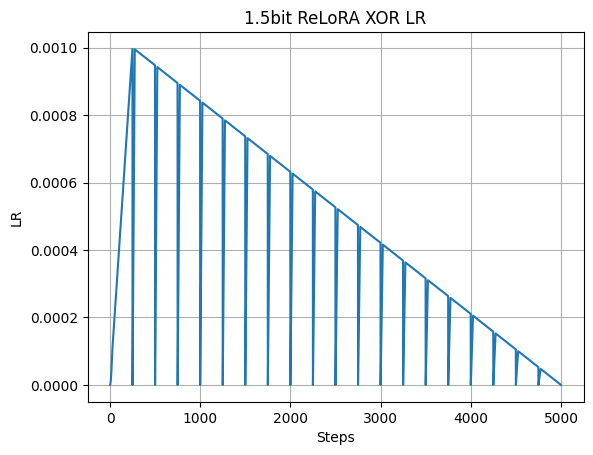

In [ ]:
if torch.cuda.is_available():
    test_training_cuda_autocast()

Okay, looks fine

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()